In [1]:
import sys
sys.path.append('/NDDepth/src')

In [2]:
from PIL import Image
import torch
import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from model import Model, ModelConfig
from dataloader.BaseDataloader import BaseImageDataset
from dataloader.NYUDataloader import NYUImageData

from loss import silog_loss, get_metrics

torch.manual_seed(42)

device = "cuda"

In [3]:
TRAIN_BATCH_SIZE = 6

train_dataset = BaseImageDataset('train', NYUImageData, '/scratchdata/nyu_depth_v2/sync', '/scratchdata/nyu_depth_v2/sync/train.csv')
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)

config =  ModelConfig("tiny07")
config.batch_size = TRAIN_BATCH_SIZE
config.height = 480//4
config.width = 640//4
model = Model(config).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
model.train()
for i, x in enumerate(tqdm.tqdm(train_dataloader)):
    
    for k in x.keys():
        x[k] = x[k].to(device)

    d1_list, u1, d2_list, u2 = model(x)

    gt = x["depth_values"]
    for i in range(len(d1_list)): d1_list[i] = F.interpolate(d1_list[i], size=gt.shape[2:], mode='bilinear', align_corners=False)
    for i in range(len(d2_list)): d2_list[i] = F.interpolate(d2_list[i], size=gt.shape[2:], mode='bilinear', align_corners=False)
    u1 = F.interpolate(u1, size=gt.shape[2:], mode='bilinear', align_corners=False)
    u2 = F.interpolate(u2, size=gt.shape[2:], mode='bilinear', align_corners=False)

    uncer1_gt = torch.exp(-5 * torch.abs(gt - d1_list[0].detach()) / (gt + d1_list[0].detach() + 1e-7))
    uncer2_gt = torch.exp(-5 * torch.abs(gt - d2_list[0].detach()) / (gt + d2_list[0].detach() + 1e-7))
    
    loss_uncer1 = torch.abs(u1-uncer1_gt)[x["mask"]].mean()
    loss_uncer2 = torch.abs(u2-uncer2_gt)[x["mask"]].mean()

    loss_depth1_0 = silog_loss(d1_list[0], gt, x["mask"])
    loss_depth2_0 = silog_loss(d2_list[0], gt, x["mask"])

    loss_depth1 = 0
    loss_depth2 = 0
    weights_sum = 0
    for i in range(len(d1_list) - 1):
        loss_depth1 += (0.85**(len(d1_list)-i-2)) * silog_loss(d1_list[i + 1], gt, x["mask"])
        loss_depth2 += (0.85**(len(d2_list)-i-2)) * silog_loss(d2_list[i + 1], gt, x["mask"])
        weights_sum += 0.85**(len(d1_list)-i-2)

    loss = (loss_depth1 + loss_depth2) / weights_sum + loss_depth1_0 + loss_depth2_0 + loss_uncer1 + loss_uncer2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break

  0%|          | 0/4853 [00:01<?, ?it/s]


RuntimeError: The size of tensor a (160) must match the size of tensor b (640) at non-singleton dimension 3

In [ ]:
print(x["camera_intrinsics"])

tensor([[[518.8579,   0.0000, 325.5824,   0.0000],
         [  0.0000, 518.8579, 253.7362,   0.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]],

        [[518.8579,   0.0000, 325.5824,   0.0000],
         [  0.0000, 518.8579, 253.7362,   0.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]],

        [[518.8579,   0.0000, 325.5824,   0.0000],
         [  0.0000, 518.8579, 253.7362,   0.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]],

        [[518.8579,   0.0000, 325.5824,   0.0000],
         [  0.0000, 518.8579, 253.7362,   0.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]],

        [[518.8579,   0.0000, 325.5824,   0.0000],
         [  0.0000, 518.8579, 253.7362,   0.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0

In [ ]:
for k in x.keys():
    x[k] = x[k].cpu()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([6, 3, 480, 640])
tensor(1.)


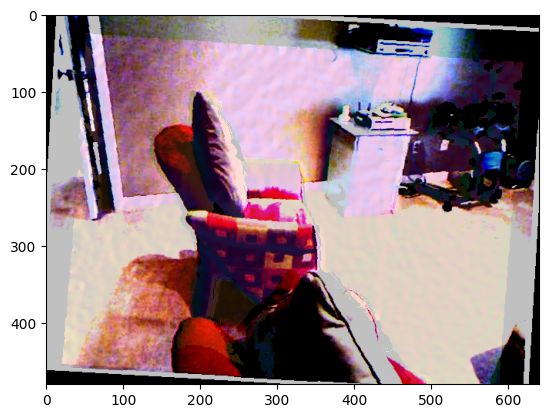

In [ ]:
print(x["normal_values"].shape)
print(x["normal_values"][0].max())

plt.imshow(x["pixel_values"][0].squeeze().permute(1, 2, 0))
plt.imshow(x["normal_values"][0].squeeze().permute(1, 2, 0),alpha=0.25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


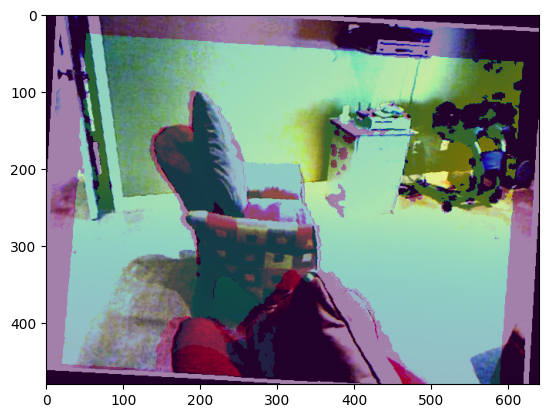

In [ ]:
plt.imshow(x["pixel_values"][0].squeeze().permute(1, 2, 0))
plt.imshow(x["depth_values"][0].squeeze(), alpha=0.5)